# Notebook 02 — Seasonal QC and Phenology

This notebook shows the data quality and seasonal shape of NDVI/NDRE derived from the CDL-filtered corn tiles. It reports class balance, deficit threshold, distributions, and mean curves with first derivatives and phase shading. Use it to visually confirm the curves follow expected corn phenology and that deficit labels separate well from healthy.

In [14]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

INTERIM = Path("data/interim")
DOY = np.array([145, 169, 186, 206, 224], dtype=float)  # midpoints for the 5 seasonal windows


def load(name: str):
    return np.load(INTERIM / name)

ndre_tr = load("ndre_ts_train.npy")
ndre_val = load("ndre_ts_val.npy")
ndre_te = load("ndre_ts_test.npy")

ndvi_tr = load("ndvi_ts_train.npy")
ndvi_val = load("ndvi_ts_val.npy")
ndvi_te = load("ndvi_ts_test.npy")

y_tr = load("y_train_deficit_label.npy")
y_val = load("y_val_deficit_label.npy")
y_te = load("y_test_deficit_label.npy")

with open(INTERIM / "deficit_threshold.txt") as f:
    threshold_txt = f.read().strip()


def describe(split: str, arr: np.ndarray, labels: np.ndarray):
    pos_rate = float(np.mean(labels))
    print(f"{split:<5} shape={arr.shape}, positives={pos_rate:.3f}")

print("Loaded NDRE / NDVI time series (samples, time)")
describe("train", ndre_tr, y_tr)
describe("val", ndre_val, y_val)
describe("test", ndre_te, y_te)
print("Deficit threshold info:" + threshold_txt)


Loaded NDRE / NDVI time series (samples, time)
train shape=(317, 5), positives=0.470
val   shape=(108, 5), positives=0.602
test  shape=(39, 5), positives=0.410
Deficit threshold info:train_mean=0.19231349229812622
train_std=0.12069646269083023
q47.0=0.1881776750087738
train_rate=0.4700
val_rate=0.6019
test_rate=0.4103


### Graph: NDVI / NDRE distributions
These KDE plots show the probability density of NDVI and NDRE values for train, val, and test splits. They let you quickly see if splits are similarly distributed, spot skew/NaNs, and confirm indices live in plausible ranges (NDVI ≈ -0.5 to 1.0, NDRE ≈ 0 to ~0.6).

### Graph: Seasonal NDVI / NDRE with first derivatives
This panel shows mean NDVI and NDRE over the five acquisition windows (DOY midpoints), with ±1 standard deviation and finite-difference derivatives on twin axes. Shaded regions mark vegetative and reproductive phases. Look for the expected rise mid-season and decline late-season; derivatives highlight growth/decline rates.

### Graph: NDRE stratified by deficit label
This plot separates the train mean NDRE trajectory for deficit vs healthy labels, with ±1 sd bands. It shows whether the deficit label corresponds to lower NDRE (canopy stress) across the season. If one class is missing, the code prints a note instead.

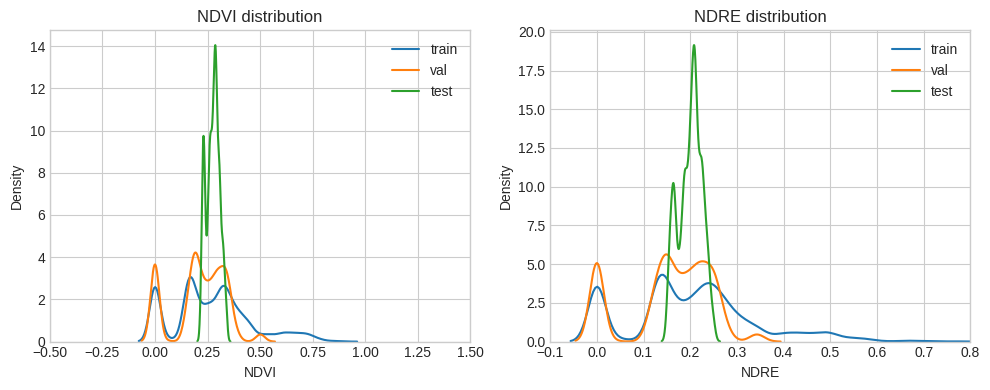

In [15]:
# NDVI / NDRE distributions by split
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for arr, name, ax in [
    (ndvi_tr, "train", axes[0]), (ndvi_val, "val", axes[0]), (ndvi_te, "test", axes[0])
]:
    sns.kdeplot(arr[np.isfinite(arr)].flatten(), label=name, bw_adjust=0.6, ax=ax)
axes[0].set_title("NDVI distribution")
axes[0].set_xlim(-0.5, 1.5)
axes[0].set_xlabel("NDVI")
axes[0].legend()

for arr, name, ax in [
    (ndre_tr, "train", axes[1]), (ndre_val, "val", axes[1]), (ndre_te, "test", axes[1])
]:
    sns.kdeplot(arr[np.isfinite(arr)].flatten(), label=name, bw_adjust=0.6, ax=ax)
axes[1].set_title("NDRE distribution")
axes[1].set_xlim(-0.1, 0.8)
axes[1].set_xlabel("NDRE")
axes[1].legend()

plt.tight_layout()
plt.show()


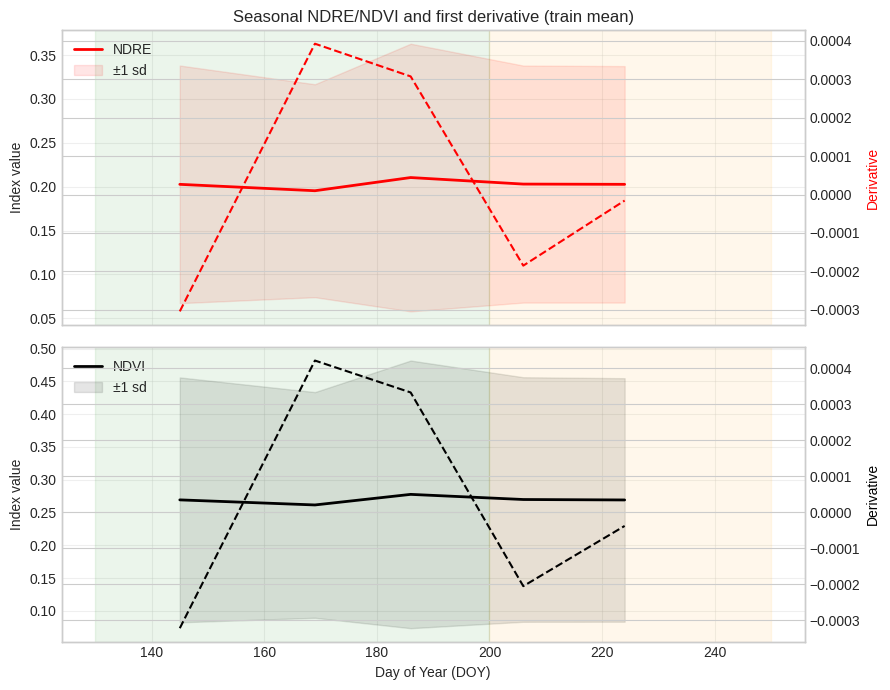

In [16]:
# Seasonal NDVI / NDRE means (train) with first derivatives
mean_ndre = np.nanmean(ndre_tr, axis=0)
mean_ndvi = np.nanmean(ndvi_tr, axis=0)

ndre_sd = np.nanstd(ndre_tr, axis=0)
ndvi_sd = np.nanstd(ndvi_tr, axis=0)

ndre_der = np.gradient(mean_ndre, DOY)
ndvi_der = np.gradient(mean_ndvi, DOY)

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# NDRE panel
a = axes[0]
a.plot(DOY, mean_ndre, color="red", lw=2, label="NDRE")
a.fill_between(DOY, mean_ndre - ndre_sd, mean_ndre + ndre_sd, color="red", alpha=0.1, label="±1 sd")
ax2 = a.twinx()
ax2.plot(DOY, ndre_der, color="red", ls="--", lw=1.5, label="d(NDRE)/d(DOY)")
ax2.set_ylabel("Derivative", color="red")

# NDVI panel
b = axes[1]
b.plot(DOY, mean_ndvi, color="black", lw=2, label="NDVI")
b.fill_between(DOY, mean_ndvi - ndvi_sd, mean_ndvi + ndvi_sd, color="black", alpha=0.1, label="±1 sd")
b2 = b.twinx()
b2.plot(DOY, ndvi_der, color="black", ls="--", lw=1.5, label="d(NDVI)/d(DOY)")
b2.set_ylabel("Derivative", color="black")

# Phase shading
for ax in (a, b):
    ax.axvspan(130, 200, color="green", alpha=0.08)
    ax.axvspan(200, 250, color="orange", alpha=0.08)
    ax.set_ylabel("Index value")
    ax.grid(alpha=0.3)
axes[1].set_xlabel("Day of Year (DOY)")
axes[0].set_title("Seasonal NDRE/NDVI and first derivative (train mean)")

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()


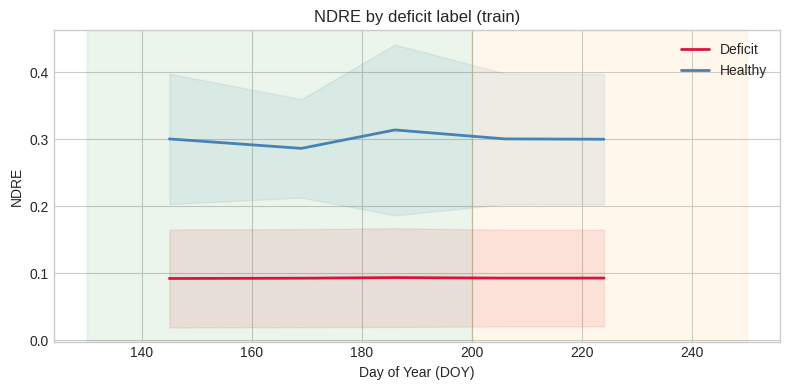

In [17]:
# Stratified NDRE by deficit label (train)
pos_mask = y_tr == 1
neg_mask = y_tr == 0

if pos_mask.sum() > 0 and neg_mask.sum() > 0:
    ndre_pos = np.nanmean(ndre_tr[pos_mask], axis=0)
    ndre_neg = np.nanmean(ndre_tr[neg_mask], axis=0)
    sd_pos = np.nanstd(ndre_tr[pos_mask], axis=0)
    sd_neg = np.nanstd(ndre_tr[neg_mask], axis=0)

    plt.figure(figsize=(8, 4))
    plt.plot(DOY, ndre_pos, color="crimson", lw=2, label="Deficit")
    plt.fill_between(DOY, ndre_pos - sd_pos, ndre_pos + sd_pos, color="crimson", alpha=0.1)
    plt.plot(DOY, ndre_neg, color="steelblue", lw=2, label="Healthy")
    plt.fill_between(DOY, ndre_neg - sd_neg, ndre_neg + sd_neg, color="steelblue", alpha=0.1)
    plt.axvspan(130, 200, color="green", alpha=0.08)
    plt.axvspan(200, 250, color="orange", alpha=0.08)
    plt.xlabel("Day of Year (DOY)")
    plt.ylabel("NDRE")
    plt.title("NDRE by deficit label (train)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough positives/negatives to plot stratified NDRE.")


### Quantitative snapshot
Quick stats to pair with the QC plots: class balance per split, NDVI/NDRE moments, and how the deficit label shifts NDRE/NDVI on train.

In [19]:
import pandas as pd

def split_summary(split, ndre, ndvi, y):
    return {
        'split': split,
        'n': len(y),
        'pos_rate': float(y.mean()),
        'ndre_mean': float(np.nanmean(ndre)),
        'ndre_sd': float(np.nanstd(ndre)),
        'ndvi_mean': float(np.nanmean(ndvi)),
        'ndvi_sd': float(np.nanstd(ndvi)),
    }

splits = [
    split_summary('train', ndre_tr, ndvi_tr, y_tr),
    split_summary('val', ndre_val, ndvi_val, y_val),
    split_summary('test', ndre_te, ndvi_te, y_te),
]

summary_df = pd.DataFrame(splits).set_index('split')

label_df = pd.DataFrame({
    'class': ['deficit', 'healthy'],
    'ndre_mean': [float(np.nanmean(ndre_tr[y_tr==1])), float(np.nanmean(ndre_tr[y_tr==0]))],
    'ndvi_mean': [float(np.nanmean(ndvi_tr[y_tr==1])), float(np.nanmean(ndvi_tr[y_tr==0]))],
})

display(summary_df.round(3))
print('Train label stratification (means):')
display(label_df.round(3))


,n,pos_rate,ndre_mean,ndre_sd,ndvi_mean,ndvi_sd
split,,,,,,
train,317,0.470,0.203,0.136,0.269,0.187
val,108,0.602,0.157,0.090,0.212,0.124
test,39,0.410,0.200,0.024,0.276,0.031


Train label stratification (means):


,class,ndre_mean,ndvi_mean
0,deficit,0.093,0.116
1,healthy,0.300,0.406
